## (Lab 1) Importing  and cleaning data

&nbsp;  
&nbsp;
**Import packages**

In [ ]:
import requests
import pandas as pd
import numpy as np
import datetime
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

&nbsp;  
&nbsp;
**Define helper functions**

In [ ]:
def getBoosterVersion(data):
    for x in data['rocket']:
       if x:
        response = requests.get("https://api.spacexdata.com/v4/rockets/"+str(x)).json()
        BoosterVersion.append(response['name'])
        
def getPayloadData(data):
    for load in data['payloads']:
       if load:
        response = requests.get("https://api.spacexdata.com/v4/payloads/"+load).json()
        PayloadMass.append(response['mass_kg'])
        Orbit.append(response['orbit'])
        
def getLaunchSite(data):
    for x in data['launchpad']:
       if x:
         response = requests.get("https://api.spacexdata.com/v4/launchpads/"+str(x)).json()
         Longitude.append(response['longitude'])
         Latitude.append(response['latitude'])
         LaunchSite.append(response['name'])

def getCoreData(data):
    for core in data['cores']:
            if core['core'] != None:
                response = requests.get("https://api.spacexdata.com/v4/cores/"+core['core']).json()
                Block.append(response['block'])
                ReusedCount.append(response['reuse_count'])
                Serial.append(response['serial'])
            else:
                Block.append(None)
                ReusedCount.append(None)
                Serial.append(None)
            Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
            Flights.append(core['flight'])
            GridFins.append(core['gridfins'])
            Reused.append(core['reused'])
            Legs.append(core['legs'])
            LandingPad.append(core['landpad'])

&nbsp;  
&nbsp;
**Collect and clean data**

In [ ]:
# Get data from static URL
static_json_url='https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/API_call_spacex_api.json'
response = requests.get(static_json_url)
response.status_code
data = pd.json_normalize(response.json())
data.head()

# Get data from Space X API
spacex_url="https://api.spacexdata.com/v4/launches/past"
response = requests.get(spacex_url)
#print(response.content)

In [ ]:
# Clean the data a bit
data = data[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]
data = data[data['cores'].map(len)==1]
data = data[data['payloads'].map(len)==1]
data['cores'] = data['cores'].map(lambda x : x[0])
data['payloads'] = data['payloads'].map(lambda x : x[0])
data['date'] = pd.to_datetime(data['date_utc']).dt.date
data = data[data['date'] <= datetime.date(2020, 11, 13)]

In [ ]:
# Recover additional data from other sources (SpaceX API)

# Global variables definition
BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []
Longitude = []
Latitude = []

# Recover data
getBoosterVersion(data)
getLaunchSite(data)
getPayloadData(data)
getCoreData(data)

# Create the final DS with collected data
launch_dict = {'FlightNumber': list(data['flight_number']),
               'Date': list(data['date']),
               'BoosterVersion':BoosterVersion,
               'PayloadMass':PayloadMass,
               'Orbit':Orbit,
               'LaunchSite':LaunchSite, 
               'Outcome':Outcome,
               'Flights':Flights,
               'GridFins':GridFins,
               'Reused':Reused,
               'Legs':Legs,
               'LandingPad':LandingPad,
               'Block':Block,
               'ReusedCount':ReusedCount,
               'Serial':Serial,
               'Longitude': Longitude,
               'Latitude': Latitude}

# Create DF
launch_df = pd.DataFrame.from_dict(launch_dict)
launch_df.head()

In [ ]:
# Filter Falcon 9 Data
data_falcon9 = launch_df[launch_df['BoosterVersion'] == 'Falcon 9']
data_falcon9.loc[:,'FlightNumber'] = list(range(1, data_falcon9.shape[0]+1))
data_falcon9.head()
data_falcon9.head().isnull().sum()

In [ ]:
# Fixing missing values
PayloadMass_mean = data_falcon9.PayloadMass.mean()
data_falcon9['PayloadMass'] = data_falcon9['PayloadMass'].replace(np.nan, PayloadMass_mean)
data_falcon9.isnull().sum()

&nbsp;  
&nbsp;
**Additional data collection with web scraping**

In [ ]:
# setup
#!pip3 install beautifulsoup4
#!pip3 install requests
import sys
import requests
from bs4 import BeautifulSoup
import re
import unicodedata
import pandas as pd

In [ ]:
# define helper functions
def date_time(table_cells):
    """
    This function returns the data and time from the HTML  table cell
    Input: the  element of a table data cell extracts extra row
    """
    return [data_time.strip() for data_time in list(table_cells.strings)][0:2]

def booster_version(table_cells):
    """
    This function returns the booster version from the HTML  table cell 
    Input: the  element of a table data cell extracts extra row
    """
    out=''.join([booster_version for i,booster_version in enumerate( table_cells.strings) if i%2==0][0:-1])
    return out

def landing_status(table_cells):
    """
    This function returns the landing status from the HTML table cell 
    Input: the  element of a table data cell extracts extra row
    """
    out=[i for i in table_cells.strings][0]
    return out


def get_mass(table_cells):
    mass=unicodedata.normalize("NFKD", table_cells.text).strip()
    if mass:
        mass.find("kg")
        new_mass=mass[0:mass.find("kg")+2]
    else:
        new_mass=0
    return new_mass


def extract_column_from_header(row):
    """
    This function returns the landing status from the HTML table cell 
    Input: the  element of a table data cell extracts extra row
    """
    if (row.br):
        row.br.extract()
    if row.a:
        row.a.extract()
    if row.sup:
        row.sup.extract()
        
    colunm_name = ' '.join(row.contents)
    
    # Filter the digit and empty names
    if not(colunm_name.strip().isdigit()):
        colunm_name = colunm_name.strip()
        return colunm_name 

In [ ]:
# Fix libraries
#!pip install bs4
#!pip install html5lib
#!pip install lxml
import bs4
import html5lib
import lxml

In [ ]:
# Request data
#!pip3 install html5lib
#import html5lib
static_url = "https://en.wikipedia.org/w/index.php?title=List_of_Falcon_9_and_Falcon_Heavy_launches&oldid=1027686922"
page=requests.get(static_url)
soup = BeautifulSoup(page.text, 'html.parser')
soup.title
html_tables=soup.find_all('table')

In [ ]:
# Extract and clean tables
html_tables = soup.find_all('table')
first_launch_table = html_tables[2]

column_names = []
# Apply find_all() function with `th` element on first_launch_table
# Iterate each th element and apply the provided extract_column_from_header() to get a column name
# Append the Non-empty column name (`if name is not None and len(name) > 0`) into a list called column_names
for i in first_launch_table.find_all('th'):
    if extract_column_from_header(i)!=None:
        if len(extract_column_from_header(i))>0:
            column_names.append(extract_column_from_header(i))
column_names

launch_dict= dict.fromkeys(column_names)

# Remove an irrelvant column
del launch_dict['Date and time ( )']

# Let's initial the launch_dict with each value to be an empty list
launch_dict['Flight No.'] = []
launch_dict['Launch site'] = []
launch_dict['Payload'] = []
launch_dict['Payload mass'] = []
launch_dict['Orbit'] = []
launch_dict['Customer'] = []
launch_dict['Launch outcome'] = []
launch_dict['Version Booster']=[]
launch_dict['Booster landing']=[]
launch_dict['Date']=[]
launch_dict['Time']=[]

extracted_row = 0
#Extract each table 
for table_number,table in enumerate(soup.find_all('table',"wikitable plainrowheaders collapsible")):
   # get table row 
    for rows in table.find_all("tr"):
        #check to see if first table heading is as number corresponding to launch a number 
        if rows.th:
            if rows.th.string:
                flight_number=rows.th.string.strip()
                flag=flight_number.isdigit()
        else:
            flag=False
        #get table element 
        row=rows.find_all('td')
        #if it is number save cells in a dictonary 
        if flag:
            extracted_row += 1
            # Flight Number value
            # TODO: Append the flight_number into launch_dict with key `Flight No.`
            launch_dict['Flight No.'].append(flight_number)
            print(flight_number)
            datatimelist=date_time(row[0])
            
            # Date value
            # TODO: Append the date into launch_dict with key `Date`
            date = datatimelist[0].strip(',')
            launch_dict['Date'].append(date)
            print(date)
            
            # Time value
            # TODO: Append the time into launch_dict with key `Time`
            time = datatimelist[1]
            launch_dict['Time'].append(time)
            print(time)
              
            # Booster version
            # TODO: Append the bv into launch_dict with key `Version Booster`
            bv=booster_version(row[1])
            if not(bv):
                bv=row[1].a.string
            launch_dict['Version Booster'].append(bv)
            print(bv)
            
            # Launch Site
            # TODO: Append the bv into launch_dict with key `Launch Site`
            launch_site = row[2].a.string
            launch_dict['Launch site'].append(launch_site)
            print(launch_site)
            
            # Payload
            # TODO: Append the payload into launch_dict with key `Payload`
            payload = row[3].a.string
            launch_dict['Payload'].append(payload)
            print(payload)
            
            # Payload Mass
            # TODO: Append the payload_mass into launch_dict with key `Payload mass`
            payload_mass = get_mass(row[4])
            launch_dict['Payload mass'].append(payload_mass)
            print(payload_mass)
            
            # Orbit
            # TODO: Append the orbit into launch_dict with key `Orbit`
            orbit = row[5].a.string
            launch_dict['Orbit'].append(orbit)
            print(orbit)
            
            # Customer
            # TODO: Append the customer into launch_dict with key `Customer`
            if row[6].a!=None:
                customer = row[6].a.string
            else: 
                customer='None'
            launch_dict['Customer'].append(customer)
            print(customer)
            
            # Launch outcome
            # TODO: Append the launch_outcome into launch_dict with key `Launch outcome`
            launch_outcome = list(row[7].strings)[0]
            launch_dict['Launch outcome'].append(launch_outcome)
            print(launch_outcome)
            
            # Booster landing
            # TODO: Append the launch_outcome into launch_dict with key `Booster landing`
            booster_landing = landing_status(row[8])
            launch_dict['Booster landing'].append(booster_landing)
            print(booster_landing)
            
            print("******")
            

In [ ]:
df=pd.DataFrame(launch_dict)
df.to_csv('spacex_web_scraped.csv', index=False)
df.head()

In [ ]:
len(data)

## (Lab 2) Data Wrangling

**Load data + overview**

In [ ]:
# Load and overview
df=pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_1.csv")
df.head(10)
df.isnull().sum()/df.count()*100
df.dtypes

In [ ]:
# Count launches
df['LaunchSite'].value_counts()

In [ ]:
# Count orbits
df.Orbit.value_counts()

In [ ]:
# Landing outcomes
landing_outcomes = df.Outcome.value_counts()
landing_outcomes

In [ ]:
# create landing outcoes column
bad_outcomes=set(landing_outcomes.keys()[[1,3,5,6,7]])

landing_class = []
for outcome in df.Outcome:
    if outcome in bad_outcomes:
        landing_class.append(0)
    else:
        landing_class.append(1)

df['Class']=landing_class
df[['Class']].head()
df.head(5)
df["Class"].mean()

## (Lab 3) EDA

In [ ]:
# Setup:
import matplotlib.pyplot as plt
import seaborn as sns
df=pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv")
df.head()

In [ ]:
# Flight number, Payload
sns.catplot(y="PayloadMass", x="FlightNumber", hue="Class", data=df, aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Pay load Mass (kg)",fontsize=20)
plt.title('Flight number, Payload')
plt.show()

In [ ]:
# Launch site, flight number, class (fail/ok)
sns.catplot(y='LaunchSite', x='FlightNumber', hue='Class', data=df)
plt.xlabel('Flight Number')
plt.ylabel('Launch Site')
plt.title('Launch site, flight number, class (fail/ok)')
plt.show()

In [ ]:
# Launch site, payload, class (fail/ok)
sns.catplot(y='LaunchSite', x='PayloadMass', hue='Class', data=df)
plt.xlabel('Pay Load Mass (kg)')
plt.ylabel('Launch Site')
plt.title('Launch site, payload, class (fail/ok)')
plt.show()

In [ ]:
# success rate x orbit type
df_sorted = df.groupby('Orbit').mean()['Class'].reset_index().sort_values(['Class'], ascending=True)
fig, ax = plt.subplots()
ax.barh(df_sorted.Orbit, df_sorted.Class * 100)
plt.xlabel('Success Rate (%)')
plt.ylabel('Orbit Type')
plt.title('success rate x orbit type')
plt.show()

In [ ]:
# Flight number, orbit type, class (fail/ok)
sns.catplot(x='FlightNumber', y='Orbit', hue='Class', data=df)
plt.xlabel('Fligh Number')
plt.ylabel('Orbit Type')
plt.title('Flight number, orbit type, class (fail/ok)')
plt.show()

In [ ]:
# Payload, orbit type, class(fail/ok)
sns.catplot(x='PayloadMass', y='Orbit', hue='Class', data=df)
plt.xlabel('Pay load Mass (kg)')
plt.ylabel('Orbit Type')
plt.title('Payload, orbit type, class(fail/ok)')
plt.show()

In [ ]:
# launch success yearly trend
year=[]
def Extract_year(date):
    for i in df["Date"]:
        year.append(i.split("-")[0])
    return year

df.groupby(Extract_year(df['Date'])).mean()['Class'].plot(kind='line')
plt.xlabel('Year')
plt.ylabel('Success Rate')
plt.title('launch success over time')
plt.show()

**Create dummies and fix numeric columns**

In [ ]:
features = df[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial']]
features_one_hot = pd.get_dummies(features, columns=['Orbit', 'LaunchSite', 'LandingPad', 'Serial'])
features_one_hot.astype('float64')

## (Lab 4) Interactive visualization

**Folium visualizations**

In [ ]:
# Setup
#!pip3 install folium
#!pip3 install wget
import folium
import wget
from folium.plugins import MarkerCluster
from folium.plugins import MousePosition
from folium.features import DivIcon

spacex_csv_file = wget.download('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/spacex_launch_geo.csv')
spacex_df=pd.read_csv(spacex_csv_file)
spacex_df = spacex_df[['Launch Site', 'Lat', 'Long', 'class']]
launch_sites_df = spacex_df.groupby(['Launch Site'], as_index=False).first()
launch_sites_df = launch_sites_df[['Launch Site', 'Lat', 'Long', 'class']]
launch_sites_df

In [ ]:
# First map
nasa_coordinate = [29.559684888503615, -95.0830971930759]
site_map = folium.Map(location=nasa_coordinate, zoom_start=10)
circle = folium.Circle(nasa_coordinate, radius=1000, color='#007fd3', fill=True).add_child(folium.Popup('NASA Johnson Space Center'))
marker = folium.map.Marker(
    nasa_coordinate,
    # Create an icon as a text label
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='%s' % 'NASA JSC',
            )
        )
site_map.add_child(circle)
site_map.add_child(marker)

In [ ]:
# Second map
# Initial the map
site_map = folium.Map(location=nasa_coordinate, zoom_start=5)
# For each launch site, add a Circle object based on its coordinate (Lat, Long) values. In addition, add Launch site name as a popup label
for lat, lng, label in zip(launch_sites_df['Lat'], launch_sites_df['Long'], launch_sites_df['Launch Site']):
    coordinate = [lat, lng]
    circle = folium.Circle(coordinate, radius=1000, color='#d35400', fill=True).add_child(folium.Popup(label))
    marker = folium.map.Marker(
        coordinate, 
        icon=DivIcon(
            icon_size=(20,20),
            icon_anchor=(0,0), 
            html='%s' % label, 
            )
        )
    site_map.add_child(circle)
    site_map.add_child(marker)

site_map

In [ ]:
# Third map
marker_cluster = MarkerCluster()

# create column in df

# f1
def assign_marker_color_LSDF(launch_class):
    if launch_class == 1:
        return 'green'
    else:
        return 'red'

launch_sites_df['marker_color'] = launch_sites_df['class'].apply(assign_marker_color_LSDF)

# f2
def assign_marker_color(launch_outcome):
    if launch_outcome == 1:
        return 'green'
    else:
        return 'red'
    
spacex_df['marker_color'] = spacex_df['class'].apply(assign_marker_color)
                                                     
# Add markers to map
for lat, lng, label, color in zip(spacex_df['Lat'], spacex_df['Long'], spacex_df['Launch Site'], spacex_df['marker_color']):
                                                     coordinate = [lat, lng]
                                                     marker = folium.Marker(
                                                         coordinate,
                                                         icon=folium.Icon(color='white', icon_color=color),
                                                         popup=label)
                                                     marker_cluster.add_child(marker)

site_map

In [ ]:
# Map 4
marker_cluster = MarkerCluster()

def assign_marker_color_LSDF(launch_class):
    if launch_class == 1:
        return 'green'
    else:
        return 'red'

launch_sites_df['marker_color'] = launch_sites_df['class'].apply(assign_marker_color_LSDF)
launch_sites_df

def assign_marker_color(launch_outcome):
    if launch_outcome == 1:
        return 'green'
    else:
        return 'red'
    
spacex_df['marker_color'] = spacex_df['class'].apply(assign_marker_color)
spacex_df.tail(10)

site_map.add_child(marker_cluster)

for lat, lng, label, color in zip(spacex_df['Lat'], spacex_df['Long'], spacex_df['Launch Site'], spacex_df['marker_color']):
    coordinate = [lat, lng]
    marker = folium.Marker(
        coordinate, 
        icon=folium.Icon(color='white', icon_color=color),
        popup=label
    )
    marker_cluster.add_child(marker)

site_map

In [ ]:
# Calculation of proximities
formatter = "function(num) {return L.Util.formatNum(num, 5);};"
mouse_position = MousePosition(
    position='topright',
    separator=' Long: ',
    empty_string='NaN',
    lng_first=False,
    num_digits=20,
    prefix='Lat:',
    lat_formatter=formatter,
    lng_formatter=formatter,
)

site_map.add_child(mouse_position)
site_map

In [ ]:
# Calculate positions

from math import sin, cos, sqrt, atan2, radians

def calculate_distance(lat1, lon1, lat2, lon2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

In [ ]:
# find coordinate of the closet coastline
coastline_lat = 28.56398
coastline_lon = -80.56809
launch_site_lat = 28.56321
launch_site_lon = -80.57683
distance_coastline = calculate_distance(launch_site_lat, launch_site_lon, coastline_lat, coastline_lon)

In [ ]:
# Display the distance between coastline point and launch site using the icon property 
coast_coordinates = [coastline_lat, coastline_lon]
distance_marker = folium.Marker(
    coast_coordinates,
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='%s' % "{:10.2f} KM".format(distance_coastline),
        )
    )
distance_marker.add_to(site_map)
site_map

In [ ]:
# Create a `folium.PolyLine` object using the coastline coordinates and launch site coordinate
launch_site_coordinates = [launch_site_lat, launch_site_lon]
lines=folium.PolyLine(locations=[coast_coordinates, launch_site_coordinates], weight=1)
site_map.add_child(lines)

In [ ]:
# Create a marker with distance to a closest city, railway, highway, etc.
city_lat = 28.61208
city_lon = -80.80764
distance_city = calculate_distance(launch_site_lat, launch_site_lon, city_lat, city_lon)

city_coordinates = [city_lat, city_lon]
distance_marker = folium.Marker(
    city_coordinates,
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='%s' % "{:10.2f} KM".format(distance_city),
        )
    )
distance_marker.add_to(site_map)

launch_site_coordinates = [launch_site_lat, launch_site_lon]
lines=folium.PolyLine(locations=[city_coordinates, launch_site_coordinates], weight=1)
site_map.add_child(lines)
site_map

In [ ]:
# Draw a line between the closest railway to the launch site
railway_lat = 28.57208
railway_lon = -80.58527
distance_railway = calculate_distance(launch_site_lat, launch_site_lon, railway_lat, railway_lon)

railway_coordinates = [railway_lat, railway_lon]
distance_marker = folium.Marker(
    railway_coordinates,
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='%s' % "{:10.2f} KM".format(distance_railway),
        )
    )
distance_marker.add_to(site_map)

launch_site_coordinates = [launch_site_lat, launch_site_lon]
lines=folium.PolyLine(locations=[railway_coordinates, launch_site_coordinates], weight=1)
site_map.add_child(lines)
site_map

In [ ]:
# Draw a line between the closest highway to the launch site
highway_lat = 28.56478
highway_lon = -80.57103
distance_highway = calculate_distance(launch_site_lat, launch_site_lon, highway_lat, highway_lon)

highway_coordinates = [highway_lat, highway_lon]
distance_marker = folium.Marker(
    highway_coordinates,
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='%s' % "{:10.2f} KM".format(distance_highway),
        )
    )
distance_marker.add_to(site_map)

launch_site_coordinates = [launch_site_lat, launch_site_lon]
lines=folium.PolyLine(locations=[highway_coordinates, launch_site_coordinates], weight=1)
site_map.add_child(lines)
site_map

In [ ]:
# Draw a line between the closest city(Cape Canaveral) to the launch site
city_2_lat = 28.40159
city_2_lon = -80.6042
distance_city_2 = calculate_distance(launch_site_lat, launch_site_lon, city_2_lat, city_2_lon)

city_2_coordinates = [city_2_lat, city_2_lon]
distance_marker = folium.Marker(
    city_2_coordinates,
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='%s' % "{:10.2f} KM".format(distance_city_2),
        )
    )
distance_marker.add_to(site_map)

launch_site_coordinates = [launch_site_lat, launch_site_lon]
lines=folium.PolyLine(locations=[city_2_coordinates, launch_site_coordinates], weight=1)
site_map.add_child(lines)
site_map

In [ ]:
# Draw a line between the closest city(Lompoc) to the launch site(Space Launch Complex 4)
launch_site_4_lat = 34.63286
launch_site_4_lon = -120.61074
launch_site_4_coordinates = [launch_site_4_lat, launch_site_4_lon]

city_Lompoc_lat = 34.63879
city_Lompoc_lon = -120.45788
distance_city_Lompoc = calculate_distance(launch_site_4_lat, launch_site_4_lon, city_Lompoc_lat, city_Lompoc_lon)

city_Lompoc_coordinates = [city_Lompoc_lat, city_Lompoc_lon]

distance_marker = folium.Marker(
    city_Lompoc_coordinates,
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='%s' % "{:10.2f} KM".format(distance_city_Lompoc),
        )
    )
distance_marker.add_to(site_map)

lines=folium.PolyLine(locations=[city_Lompoc_coordinates, launch_site_4_coordinates], weight=1)
site_map.add_child(lines)

# Draw a line between the closest coast to the launch site(Space Launch Complex 4)
west_coast_lat = 34.63698
west_coast_lon = -120.6245
distance_west_coast = calculate_distance(launch_site_4_lat, launch_site_4_lon, west_coast_lat, west_coast_lon)

west_coast_coordinates = [west_coast_lat, west_coast_lon]

distance_marker = folium.Marker(
    west_coast_coordinates,
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='%s' % "{:10.2f} KM".format(distance_west_coast),
        )
    )
distance_marker.add_to(site_map)

lines=folium.PolyLine(locations=[west_coast_coordinates, launch_site_4_coordinates], weight=1)
site_map.add_child(lines)

# Draw a line between the closest railway to the launch site(Space Launch Complex 4)
railway_4_lat = 34.63677
railway_4_lon = -120.6236
distance_railway_4 = calculate_distance(launch_site_4_lat, launch_site_4_lon, railway_4_lat, railway_4_lon)

railway_4_coordinates = [railway_4_lat, railway_4_lon]

distance_marker = folium.Marker(
    railway_4_coordinates,
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='%s' % "{:10.2f} KM".format(distance_railway_4),
        )
    )
distance_marker.add_to(site_map)

lines=folium.PolyLine(locations=[railway_4_coordinates, launch_site_4_coordinates], weight=1)
site_map.add_child(lines)

site_map

**Plotly**

In [ ]:
# Setup
!pip install dash
import dash
import dash_html_components as html
import dash_core_components as dcc
from dash.dependencies import Input, Output
import plotly.express as px

In [ ]:
# Read the airline data into pandas dataframe
spacex_df = pd.read_csv("spacex_launch_dash.csv")
max_payload = spacex_df['Payload Mass (kg)'].max()
min_payload = spacex_df['Payload Mass (kg)'].min()

# Create a dash application
app = dash.Dash(__name__)

# Create an app layout
app.layout = html.Div(children=[html.H1('SpaceX Launch Records Dashboard',
                                        style={'textAlign': 'center', 'color': '#503D36',
                                               'font-size': 40}),
                                # TASK 1: Add a dropdown list to enable Launch Site selection
                                # The default select value is for ALL sites
                                dcc.Dropdown(id='site-dropdown',
                                            options=[
                                                {'label': 'All Sites', 'value': 'ALL'},
                                                {'label': 'CCAFS LC-40', 'value': 'CCAFS LC-40'},
                                                {'label': 'VAFB SLC-4E', 'value': 'VAFB SLC-4E'},
                                                {'label': 'KSC LC-39A', 'value': 'KSC LC-39A'},
                                                {'label': 'CCAFS SLC-40', 'value': 'CCAFS SLC-40'},
                                            ],
                                            value='ALL',
                                            placeholder="Select a Launch Site here",
                                            searchable=True
                                            ),
                                html.Br(),

                                # TASK 2: Add a pie chart to show the total successful launches count for all sites
                                # If a specific launch site was selected, show the Success vs. Failed counts for the site
                                html.Div(dcc.Graph(id='success-pie-chart')),
                                html.Br(),

                                html.P("Payload range (Kg):"),
                                # TASK 3: Add a slider to select payload range
                                #dcc.RangeSlider(id='payload-slider',...)
                                dcc.RangeSlider(id='payload-slider',
                                                min=0, max=10000, step=1000,
                                                marks={0: '0', 2500: '2500', 5000: '5000', 7500: '7500', 10000: '10000'},
                                                value=[min_payload, max_payload]),
                                # TASK 4: Add a scatter chart to show the correlation between payload and launch success
                                html.Div(dcc.Graph(id='success-payload-scatter-chart')),
                                ])

# TASK 2:
# Add a callback function for `site-dropdown` as input, `success-pie-chart` as output
# Function decorator to specify function input and output
@app.callback(Output(component_id='success-pie-chart', component_property='figure'),
              Input(component_id='site-dropdown', component_property='value'))
def get_pie_chart(entered_site):
    filtered_df = spacex_df
    if entered_site == 'ALL':
        fig = px.pie(filtered_df, values='class', 
        names='Launch Site', 
        title='Total Success Launches By Site')
        return fig
    else:
        # return the outcomes piechart for a selected site
        filtered_df = spacex_df[spacex_df['Launch Site'] == entered_site]
        filtered_df = filtered_df.groupby(['Launch Site', 'class']).size().reset_index(name='class count')
        fig = px.pie(filtered_df, values='class count', 
        names='class',
        title=f'Total Success Launched for site {entered_site}')
        return fig
# TASK 4:
# Add a callback function for `site-dropdown` and `payload-slider` as inputs, `success-payload-scatter-chart` as output
@app.callback(Output(component_id='success-payload-scatter-chart', component_property='figure'),
              [Input(component_id='site-dropdown', component_property='value'), 
              Input(component_id='payload-slider', component_property='value')])
def get_scatter_chart(entered_site, payload):
    low, high = payload
    filtered_df = spacex_df[(spacex_df['Payload Mass (kg)'] > low) & (spacex_df['Payload Mass (kg)'] < high)]       
    if entered_site == 'ALL':
        fig = px.scatter(filtered_df, x='Payload Mass (kg)', y='class', 
        color='Booster Version Category',
        title='Correlation between Payload and Success for all Sites')
        return fig
    else:
        fig = px.scatter(filtered_df[filtered_df['Launch Site'] == entered_site],
        x='Payload Mass (kg)', y='class',
        color='Booster Version Category',
        title=f'Correlation between Payload and Success for site {entered_site}')
        return fig

# Run the app
if __name__ == '__main__':
    app.run_server()

## (Lab 5) Modeling

In [129]:
# Setup
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# for later: confusion matrix
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed'])
    plt.show()

In [ ]:
# load and clean data (standardize)
data = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv")
X = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv')
Y = data['Class'].to_numpy()

transform = preprocessing.StandardScaler()
X = transform.fit_transform(X)

In [131]:
# Train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)
len(X_test)

18

**Logistic regression**

In [ ]:
# Create model
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs']}

parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression()
logreg_cv = GridSearchCV(lr, parameters, cv = 10)
logreg_cv.fit(X_train, Y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

In [ ]:
# Evaluating a model
methods = []
accuracy = []
methods.append('Logistic regression')
accuracy.append(logreg_cv.score(X_test, Y_test))
print("test set accuracy :",logreg_cv.score(X_test, Y_test))
yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

**SVM**

In [ ]:
# Create model
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()
svm_cv = GridSearchCV(svm, parameters, cv = 10)
svm_cv.fit(X_train, Y_train)
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

In [ ]:
# Calcualte accuracy
methods.append('Support vector machine')
accuracy.append(svm_cv.score(X_test, Y_test))
print("test set accuracy :",svm_cv.score(X_test, Y_test))
yhat=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

**Decision tree**

In [ ]:
# Create model
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()
tree_cv = GridSearchCV(tree,parameters,cv=10)
tree_cv.fit(X_train, Y_train)
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

In [119]:
# Calculate accuracy
methods.append('Decision tree classifier')
accuracy.append(tree_cv.score(X_test, Y_test))
print("test set accuracy :",tree_cv.score(X_test, Y_test))

test set accuracy : 0.8888888888888888


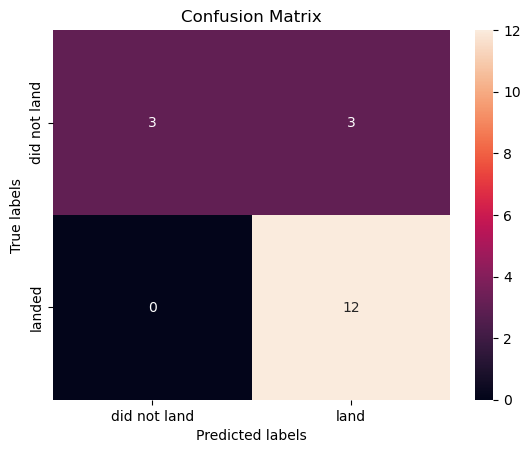

In [130]:
yhat = svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

**KNN**

In [120]:
# Create model
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

knn_cv = GridSearchCV(KNN,parameters,cv=10)
knn_cv.fit(X_train, Y_train)

print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
accuracy : 0.8482142857142858


In [121]:
# Calculate accuracy
methods.append('K nearest neighbors')
accuracy.append(knn_cv.score(X_test, Y_test))
print("test set accuracy :",knn_cv.score(X_test, Y_test))

yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

test set accuracy : 0.8333333333333334


**Model comaprison**

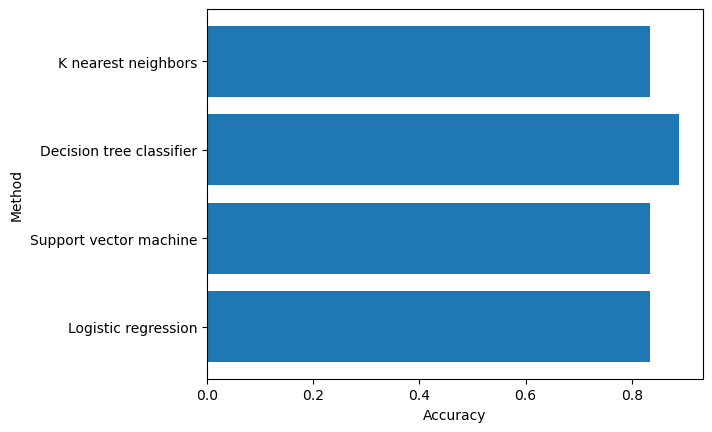

In [126]:
# OVerview
plt.barh(methods, accuracy)
plt.xlabel('Accuracy')
plt.ylabel('Method')
plt.show()